In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [2]:
class Ex1Func(object):
    
    def __init__(self, sigma=lambda x: 0.5):
        self.sigma = sigma

    def __call__(self, x):
        
        if x[0] < 0.5:
            return x[0]**2. +  self.sigma(x[0]) * np.random.randn()
        if x[0] == 0.5:
            return 1.
        if x[0] > 0.5:
            return 2. - (x[0]-0.5) ** 2.

In [3]:
from pyDOE import *

Text(0,0.5,u'$y$')

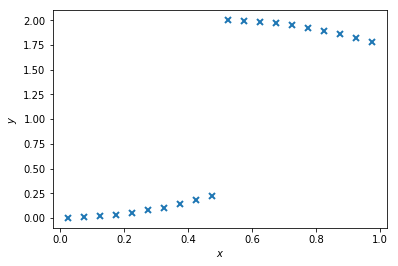

In [4]:
dim = 1
n = 20
noise=0
sigma = eval('lambda x: ' + str(noise))
objective = Ex1Func(sigma=sigma)
X = lhs(dim, n , criterion='center')
Y = np.array([objective(x) for x in X])[:, None]



#Xm = np.mean(X)
#Xv = np.std(X)
Xnorm = (X - 0.5) / 0.5

fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [5]:
#build the model
k1 = hetero_kernels.RBF(1)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptiveLengthscale(Xnorm, Y, k1, nonstat)

In [6]:
m

Name,values,prior,constraint
adaptive_lengthscale_gp.V1,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.V2,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.kern1.lengthscales,[ 1.],None,+ve
adaptive_lengthscale_gp.kern1.variance,[ 1.],None,+ve
adaptive_lengthscale_gp.likelihood.variance,[ 1.],None,+ve
adaptive_lengthscale_gp.nonstat.signal_variance,[ 1.],None,+ve


In [7]:
m.kern1.lengthscales = 0.5
m.kern1.lengthscales.fixed = True
m.kern1.variance = .1
m.kern1.variance.fixed = True
#m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern1.variance.prior = gpflow.priors.Gamma(1., 1.)

m.likelihood.variance = 0.01
m.likelihood.variance.fixed = True

#m.nonstat.signal_variance = 2.
#m.nonstat.signal_variance.fixed = True
m.nonstat.signal_variance.prior = gpflow.priors.Gamma(1., 1.)

In [8]:
m.optimize(maxiter=5000) # start near MAP

      fun: array([ 36.75274177])
 hess_inv: <41x41 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -8.90065299e-04,   9.61678164e-04,  -6.47977290e-04,
         4.03811750e-04,  -2.45392274e-04,   5.55818199e-04,
        -3.50396473e-04,  -8.64675378e-05,  -3.47613852e-04,
         1.09462918e-04,  -6.67886299e-05,  -5.94822258e-05,
        -9.74785394e-06,   7.64112227e-06,   7.48493229e-06,
        -8.54242669e-06,   2.79264525e-05,  -5.23037640e-06,
         8.98418455e-07,  -3.75639046e-06,  -2.37555846e-03,
         4.50219945e-04,  -6.60203285e-04,   2.78968267e-03,
        -1.80612223e-03,  -8.72738569e-04,   1.06414651e-03,
         5.15580472e-05,   4.91565477e-04,   2.91921255e-04,
        -1.27100776e-03,   8.19511654e-04,  -3.21599507e-04,
        -6.01040588e-06,  -2.74738527e-04,   1.49734521e-04,
        -1.74844273e-04,   8.10792698e-04,  -2.84459735e-04,
        -1.68494168e-04,   5.80571761e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [9]:
m

Name,values,prior,constraint
adaptive_lengthscale_gp.V1,[[ -2.47883954e+00] [ -5.52424424e+00] [ 7.87204751e-01] [ 1.23198753e-01] [ -2.37305380e-01] [ -2.09992428e-01] [ 2.71536209e-02] [ 4.82095504e-03] [ 6.12305022e-03] [ 2.41756465e-02] [ 5.69350733e-03] [ 1.02667032e-02] [ -3.11494569e-03] [ 1.59128073e-04] [ 2.93769617e-03] [ 1.16323486e-04] [ -2.39297208e-03] [ -3.83441080e-04] [ -8.78393196e-04] [ -1.71411292e-04]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.V2,[[ 1.41069644e-02] [ 1.01292138e+00] [ 8.44084713e-01] [ -1.19752132e-01] [ 2.81868393e-04] [ -9.75099339e-01] [ 2.49559399e-01] [ 7.30097538e-01] [ -4.93673236e-02] [ 2.85273625e-01] [ 5.67394059e-01] [ -7.02648970e-01] [ 1.69266206e-01] [ -6.41933851e-02] [ 2.70945527e-01] [ 7.35357004e-02] [ 1.04941518e+00] [ 1.15558923e-01] [ -1.22212779e+00] [ -4.19704581e-02]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.kern1.lengthscales,[ 0.5],None,[FIXED]
adaptive_lengthscale_gp.kern1.variance,[ 0.1],"Ga([ 1.],[ 1.])",[FIXED]
adaptive_lengthscale_gp.likelihood.variance,[ 0.01],None,[FIXED]
adaptive_lengthscale_gp.nonstat.signal_variance,[ 3.54924207],"Ga([ 1.],[ 1.])",+ve


In [10]:
samples = m.sample(2000, verbose=True, epsilon=0.005, thin = 2, burn = 1000, Lmax = 160)

burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  99.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  99.0 %
Iteration:  600 	 Acc Rate:  99.0 %
Iteration:  700 	 Acc Rate:  100.0 %
Iteration:  800 	 Acc Rate:  100.0 %
Iteration:  900 	 Acc Rate:  100.0 %
Iteration:  1000 	 Acc Rate:  100.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  100.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  99.0 %
Iteration:  600 	 Acc Rate:  99.0 %
Iteration:  700 	 Acc Rate:  99.0 %
Iteration:  800 	 Acc Rate:  99.0 %
Iteration:  900 	 Acc Rate:  100.0 %
Iteration:  1000 	 Acc Rate:  99.0 %
Iteration:  1100 	 Acc Rate:  100.0 %
Iteration:  1200 	 Acc Rate:  100.0 %
Iteration:  1300 	 Acc Rate:  100.0 %
Iteration:  1400 	 Acc Rate:  100.0 %
Iteration:  1500 	 Acc Rate:  100.0 %
Iteration:  1600 	 Acc Rate:  

In [11]:
xnew = np.linspace(0,1,50)[:,None]
xx = (xnew - 0.5)/0.5

In [12]:
sample_df = m.get_samples_df(samples)

In [13]:
sample_df

,adaptive_lengthscale_gp.V1,adaptive_lengthscale_gp.V2,adaptive_lengthscale_gp.kern1.lengthscales,adaptive_lengthscale_gp.kern1.variance,adaptive_lengthscale_gp.likelihood.variance,adaptive_lengthscale_gp.nonstat.signal_variance
0,"[[-1.84913901748], [-2.99430825351], [2.190520...","[[-0.049006152288], [1.02188065177], [0.704324...",[0.5],[0.1],[0.01],[3.03637986764]
1,"[[-1.23849239729], [-2.33639804485], [2.598864...","[[0.0128925820192], [0.929397103655], [0.63710...",[0.5],[0.1],[0.01],[3.63960039126]
2,"[[-1.50576615693], [-2.87328168767], [0.676196...","[[0.0100486945582], [0.892060611871], [0.64068...",[0.5],[0.1],[0.01],[3.33293182312]
3,"[[-0.644148183343], [-3.40076337045], [1.93777...","[[-0.00256120333398], [1.02148068497], [0.7714...",[0.5],[0.1],[0.01],[2.98747193167]
4,"[[-1.73466398412], [-3.1890991925], [1.9572194...","[[-0.00588280307524], [0.975555310435], [0.711...",[0.5],[0.1],[0.01],[3.00270958097]
5,"[[-2.28308129179], [-2.72882964114], [1.855204...","[[0.0317192902446], [0.838130481132], [0.61874...",[0.5],[0.1],[0.01],[3.75609736439]
6,"[[-1.83802019719], [-2.94971366785], [2.650943...","[[0.0333959685247], [1.00242013124], [0.704412...",[0.5],[0.1],[0.01],[3.19355418745]
7,"[[-0.822548675005], [-3.1334190603], [2.349007...","[[0.0683456130496], [0.967696555172], [0.54076...",[0.5],[0.1],[0.01],[3.83847090099]
8,"[[-2.20363829247], [-1.50901486006], [2.641213...","[[0.0292183082671], [0.852499006181], [0.57679...",[0.5],[0.1],[0.01],[3.93310160492]
9,"[[-2.08364747808], [-0.477149188384], [2.26329...","[[0.0207631587668], [0.97382392745], [0.638747...",[0.5],[0.1],[0.01],[3.30866077924]


In [14]:
mean_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [15]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_l(xx)
    var1 = v1[:,:]
    mean_l_mat[i,:] = mean1[:,0]
    var_l_mat[i,:] = np.diag(var1)

std_l_mat = np.sqrt(var_l_mat)

In [16]:
LowerlogL = mean_l_mat - 2*std_l_mat
UpperlogL = mean_l_mat + 2*std_l_mat

In [17]:
MeanL = np.exp(mean_l_mat)
LowerL = np.exp(LowerlogL)
UpperL = np.exp(UpperlogL)

In [18]:
mean_f_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_f_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_f(xx)
    var1 = v1[:,:]
    mean_f_mat[i,:] = mean1[:,0]
    var_f_mat[i,:] = np.diag(var1)

sig_samples = m.nonstat.signal_variance.get_samples_df(samples)
noise_samples = m.likelihood.variance.get_samples_df(samples)
signal_var = np.array([])
noise_var = np.array([])
for s in sig_samples:
    signal_var = np.append(signal_var, s)

for n in noise_samples:
    noise_var = np.append(noise_var, n)
    

In [39]:
def visualize(Xgrid, Mgrid, Vargrid, noise_var):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    Std_noise = np.sqrt(noise_var)
    signal_std = np.sqrt(signal_var)
 
    Stdgrid = np.sqrt(Vargrid)
    
    lower = Mgrid - 2*Stdgrid
    upper = Mgrid + 2*Stdgrid
    
    lower1 = lower - 2*Std_noise
    upper1 = upper + 2*Std_noise
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, Mgrid, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], lower, upper,
                     color = 'b', alpha = 0.05)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

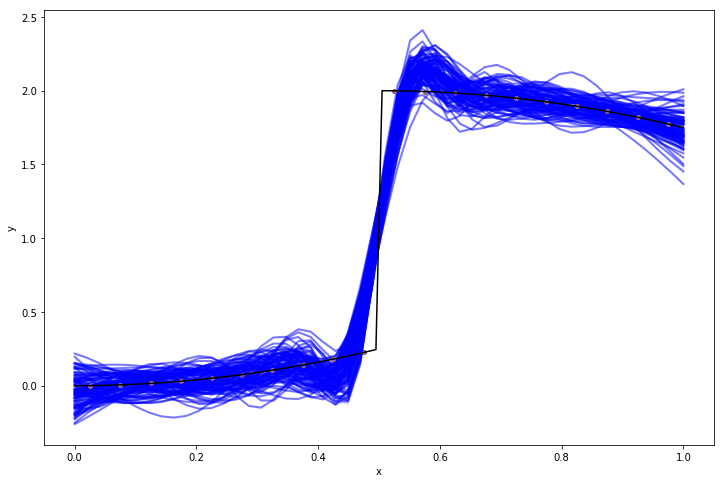

In [40]:
mini = 205
maxi = 300
plt.figure(figsize=(12,8))

for i in xrange(mini,maxi):
    visualize(xnew, mean_f_mat[i,:], var_f_mat[i,:], noise_var[i])  
plt.plot(X_true, Y_true, 'k')

In [21]:
def visualize_l(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

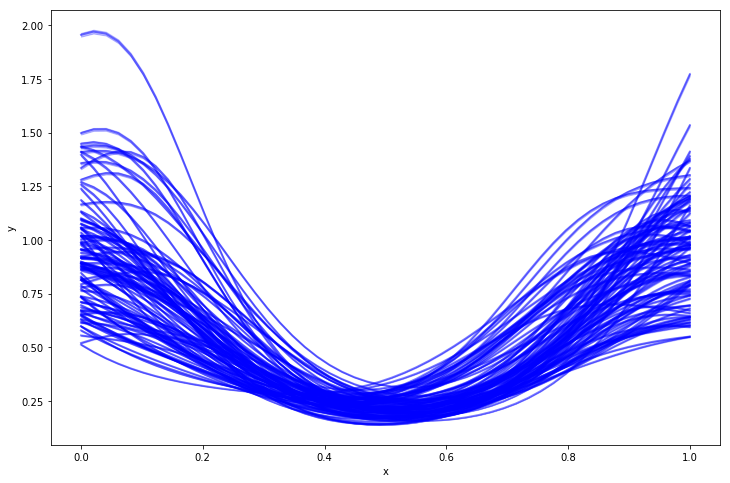

In [27]:
mini = 200
maxi = 300
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_l(xnew, MeanL[i,:], LowerL[i,:], UpperL[i,:])  

In [23]:
print Xnorm.shape
print Y[:,None].shape
print xx.shape

(20, 1)
(20, 1, 1)
(50, 1)


In [31]:
X_true = np.linspace(0,1,100)[:,None]
Y_true = np.array([objective(x) for x in X_true])[:, None]

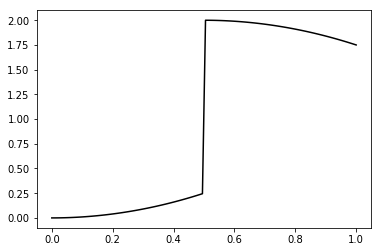

In [34]:
plt.plot(X_true, Y_true, 'k')